In [1]:
import requests
import networkx as nx
import random
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import plotly.graph_objects as go
from concurrent.futures import ThreadPoolExecutor, as_completed

Assumptions and things to keep in mind:
- We try to make the worst-case scenario modeling of our system
    - Modeling is based on Ethereum data, which is not representative of a sharded system
    - We give the most conservative parameters for our system
- We try to make the most conservative assumptions for our system
    - We give the optimistic parameters for other systems

# Latency analysis

### Get all transaction data with traces (subcalls) from a block

In [2]:
ALCHEMY_URL = ''

def get_block(block_number):
    data = {
        "jsonrpc": "2.0",
        "method": "eth_getBlockByNumber",
        "params": [hex(block_number), True],
        "id": 1
    }
    response = requests.post(ALCHEMY_URL, json=data)
    return response.json()['result']

def get_latest_block_number():
    data = {
        "jsonrpc": "2.0",
        "method": "eth_blockNumber",
        "params": [],
        "id": 1
    }
    response = requests.post(ALCHEMY_URL, json=data)
    return int(response.json()['result'], 16)

def fetch_block_traces(block_number):
    """Fetch block traces for a given block number using debug_traceBlockByNumber."""
    response = requests.post(ALCHEMY_URL, json={
        "jsonrpc": "2.0",
        "method": "debug_traceBlockByNumber",
        "params": [hex(block_number), {"tracer": "callTracer"}],
        "id": 1
    })
    return response.json().get('result', [])

In [3]:
latest_block_number = get_latest_block_number()

### Remove unnecessary data and add timestamp

- To model our system we substitute all erc20 transfers by a direct token transfer
- We also removed delegate calls to not doublecount proxy contract calls

In [4]:
def get_sub_calls(trace):
    all_calls = []

    def extract_nested_calls(call_trace):
        if 'calls' in call_trace:
            for sub_call in call_trace['calls']:
                sub_call = apply_call_filter(sub_call)
                all_calls.append(sub_call)
                extract_nested_calls(sub_call)
                
    extract_nested_calls(trace)
    return all_calls

def is_erc20_transfer(call):
    if 'input' not in call or not call['input']:
        return False
    function_signature = call['input'][:10]
    erc20_signatures = {'0xa9059cbb', '0x23b872dd'}
    return function_signature in erc20_signatures

def extract_erc_20_destination(input_data):
    return '0x' + input_data[10:74][-40:]

def apply_call_filter(call):
    if is_erc20_transfer(call):
        call['to'] = extract_erc_20_destination(call['input'])
        call['calls'] = []
    return call

def _get_clean_trace_data(block_number):
    block_traces = fetch_block_traces(block_number)
    if not block_traces:
        return [], []

    all_calls = []
    for trace in block_traces:
        all_calls.append(apply_call_filter(trace['result']))
        all_calls.extend(get_sub_calls(apply_call_filter(trace['result'])))
        
    cleaned_calls = []
    for call in all_calls:
        if 'from' in call and 'to' in call:
            call = apply_call_filter(call)
            cleaned_calls.append({
                'from': call['from'],
                'to': call['to'],
                'block_number': block_number,
                'gas_used': int(call['gasUsed'], 16),
            })

    return block_traces, cleaned_calls

def get_clean_trace_data(start_block, end_block):
    all_block_traces = []
    all_cleaned_calls = []

    with ThreadPoolExecutor() as executor:
        futures = {executor.submit(_get_clean_trace_data, block_number): block_number
                   for block_number in range(start_block, end_block + 1)}
        
        for future in as_completed(futures):
            try:
                block_traces, cleaned_calls = future.result()
                all_block_traces.extend(block_traces)
                all_cleaned_calls.extend(cleaned_calls)
            except Exception as e:
                block_number = futures[future]
                print(f"Error processing block {block_number}: {e}")

    return all_block_traces, all_cleaned_calls

### Building a graph

In [5]:
def build_temporal_graph(cleaned_data):
    G = nx.DiGraph()

    for tx in cleaned_data:
        from_address = tx['from']
        to_address = tx['to']
        timestamp = tx['block_number']

        G.add_node(from_address)
        G.add_node(to_address)
        G.add_edge(from_address, to_address, timestamp=timestamp, gas_used=tx.get('gas_used'))
    
    return G

def build_weighted_undirected_graph(cleaned_data):
    G = nx.Graph()

    for tx in cleaned_data:
        from_address = tx['from']
        to_address = tx['to']

        if G.has_edge(from_address, to_address):
            G[from_address][to_address]['weight'] += 1
        else:
            G.add_edge(from_address, to_address, weight=1)
    
    return G

### Get several blocks

In [6]:
N_blocks = 100
end_block_number = latest_block_number
start_block_number = end_block_number - N_blocks

traces_window, cleaned_traces_window = get_clean_trace_data(start_block_number, end_block_number)
G_window = build_temporal_graph(cleaned_traces_window)
G_window_undirected = build_weighted_undirected_graph(cleaned_traces_window)

In [7]:
print(f"Number of transactions in the window: {len(traces_window)}")
print(f"Number of calls in the window: {len(cleaned_traces_window)}")
print(f"Size of the temporal graph: {G_window.number_of_nodes()} nodes, {G_window.number_of_edges()} edges")
print(f"Size of the undirected graph: {G_window_undirected.number_of_nodes()} nodes, {G_window_undirected.number_of_edges()} edges")

Number of transactions in the window: 17209
Number of calls in the window: 94968
Size of the temporal graph: 19426 nodes, 31096 edges
Size of the undirected graph: 19426 nodes, 26983 edges


### Clustering

In [8]:
from sknetwork.clustering import Louvain

def random_shard_assignment(G, num_shards):
    node_to_shard = {}
    for node in G.nodes():
        node_to_shard[node] = random.randint(0, num_shards - 1)
    return node_to_shard

def chaotic_shard_assignment(G, num_shards):
    node_to_shard = {}
    for node in G.nodes():
        node_to_shard[node] = node
    return node_to_shard

louvain = Louvain()
adjacency_matrix = nx.to_numpy_array(G_window_undirected)
louvain.fit(adjacency_matrix)
labels = louvain.labels_

def clustering_shard_assignment(G, num_shards):
    node_to_shard = {node: label % num_shards for node, label in zip(G_window_undirected.nodes(), labels)}
    return node_to_shard

### Latency and CST overhead estimation

In [9]:
def get_tx_finalization_latency(tx_trace, node_to_shard):
    """
    Assumes that calls are executed sequentially in the given order.
    """
    execution_result = apply_call_filter(tx_trace['result'])
    # Check if initial transaction is cross-shard
    latency = 1
    if node_to_shard.get(execution_result['from']) != node_to_shard.get(execution_result['to']):
        latency += 1

    def _count_depth(call, depth):
        nonlocal latency
        for sub_call in call.get('calls', []):
            sub_call = apply_call_filter(sub_call)
            if node_to_shard.get(sub_call['to']) != node_to_shard.get(call['to']):
                latency = max(latency, depth + 1)
            _count_depth(sub_call, depth + 1)

    _count_depth(execution_result, 1)
    return latency

def get_tx_finalization_latency_sequential(tx_trace, node_to_shard):
    """
    Calculates the total execution latency of a transaction, including sequential
    processing of subcalls and cross-shard communication overhead.
    """
    def _calculate_latency(call, current_shard):
        latency = 0
        call = apply_call_filter(call)

        call_shard = node_to_shard.get(call['to'])
        if current_shard != call_shard:
            latency += 1
        
        for sub_call in call.get('calls', []):
            latency += _calculate_latency(sub_call, call_shard)
        
        return latency

    execution_result = apply_call_filter(tx_trace['result'])
    initial_shard = node_to_shard.get(execution_result['from'])
    return 1 + _calculate_latency(execution_result, initial_shard)

def calculate_latencies(traces_window, G_window, n_shard_values, generate_assignment, async_execution=False):
    latencies_dict = {}
    if async_execution:
        get_latency = get_tx_finalization_latency
    else:
        get_latency = get_tx_finalization_latency_sequential

    for N_shards in n_shard_values:
        node_to_shard = generate_assignment(G_window, N_shards)

        shard_latencies = [get_latency(trace, node_to_shard) 
                          for trace in traces_window]
        latencies_dict[N_shards] = shard_latencies

    return latencies_dict

def calculate_cst_overhead(traces, G, n_shard_values, generate_assignment, cst_gas_cost=10000):
    """
    Calculate the overhead introduced by cross-shard transactions (CSTs).
    
    Args:
        traces: List of transaction traces.
        G: Graph representing account interactions.
        n_shard_values: List of shard counts to evaluate.
        generate_assignment: Function to generate shard assignment.
        cst_gas_cost: Fixed gas cost for each cross-shard call.

    Returns:
        dict: Overhead values for different shard numbers.
    """
    overhead_dict = {}

    for N_shards in n_shard_values:
        node_to_shard = generate_assignment(G, N_shards)

        total_cst_overhead = 0

        for trace in traces:
            execution_result = apply_call_filter(trace['result'])
            current_shard = node_to_shard.get(execution_result['from'])

            def _process_call(call, current_shard):
                nonlocal total_cst_overhead
                call = apply_call_filter(call)
                call_shard = node_to_shard.get(call['to'])
                if current_shard != call_shard:
                    total_cst_overhead += cst_gas_cost

                for sub_call in call.get('calls', []):
                    _process_call(sub_call, call_shard)

            _process_call(execution_result, current_shard)

        overhead_dict[N_shards] = total_cst_overhead

    return overhead_dict

### Visulization of latency growth

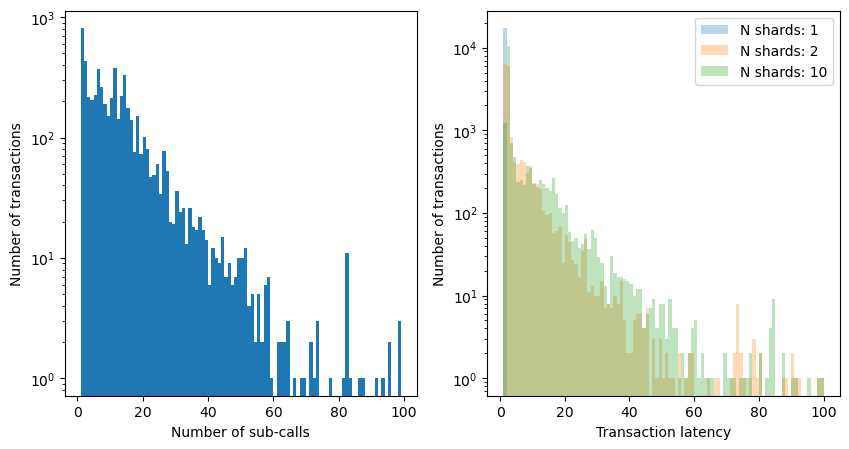

In [10]:
shards_values = [1, 2, 10]
latency_dict = calculate_latencies(traces_window, G_window, shards_values, random_shard_assignment)
num_sub_calls = [len(get_sub_calls(trace['result'])) for trace in traces_window]
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
# ax[0].hist(num_sub_calls, bins=range(1, max(num_sub_calls)), log=True) # Note that some transactions have much more than 100 sub-calls
ax[0].hist(num_sub_calls, bins=range(1, 100), log=True)
ax[0].set_xlabel("Number of sub-calls")
ax[0].set_ylabel("Number of transactions")
# plot histogram of latencies
for n_shards, latencies in latency_dict.items():
    ax[1].hist(latencies, bins=range(1, 101), log=True, label=f"N shards: {n_shards}", alpha=0.3)
ax[1].set_xlabel("Transaction latency")
ax[1].set_ylabel("Number of transactions")
ax[1].legend()
plt.show()

In [11]:
latencies_dict = {}
latencies_dict['async'] = calculate_latencies(traces_window, G_window, range(1, 11), random_shard_assignment, async_execution=True)
latencies_dict['sync'] = calculate_latencies(traces_window, G_window, range(1, 11), random_shard_assignment, async_execution=False)

In [12]:
fig = go.Figure()

for mode, latencies_dict_mode in latencies_dict.items():
    df = pd.DataFrame([
        {"n_shards": n_shards, "latency": latency}
        for n_shards, latencies in latencies_dict_mode.items()
        for latency in latencies
    ])
    # Calculate means for each shard count
    means = df.groupby("n_shards")["latency"].mean().reset_index()

    # Create the violin plot with mean markers
    fig.add_trace(go.Violin(x=df["n_shards"], y=df["latency"], name=mode,
                    box_visible=False,
                    meanline_visible=True,
                    showlegend=True))

    # Add mean points to the plot
    fig.add_trace(go.Scatter(x=means["n_shards"], y=means["latency"],
                            mode="markers+text", name=f"Mean Latency ({mode})",
                            text=means["latency"].round(2), textposition="top center",
                            marker=dict(color="blue" if mode=="async" else "red",
                                      symbol="circle" if mode=="async" else "square",
                                      size=8)))

fig.update_layout(
    yaxis_type="log",
    xaxis_title="Number of Shards",
    yaxis_title="Transaction Latency",
    yaxis_range=[None, 2]
)

fig.show()

# Cost analysis

In [19]:
cst_overhead_dict_random = calculate_cst_overhead(traces_window, G_window, range(1, 30, 2), random_shard_assignment, cst_gas_cost=10000)
cst_overhead_dict_clustering = calculate_cst_overhead(traces_window, G_window, range(1, 30, 2), clustering_shard_assignment, cst_gas_cost=10000)
total_gas_used = sum(int(trace['result']['gasUsed'], 16) for trace in traces_window)

x_values = list(cst_overhead_dict_random.keys())
y_random = [cst_overhead_dict_random[n_shards] / (total_gas_used + cst_overhead_dict_random[n_shards]) for n_shards in x_values]
y_clustering = [cst_overhead_dict_clustering[n_shards] / (total_gas_used + cst_overhead_dict_clustering[n_shards]) for n_shards in x_values]

fig = go.Figure()
fig.add_trace(go.Scatter(x=x_values, y=y_random, name="Random"))
fig.add_trace(go.Scatter(x=x_values, y=y_clustering, name="Clustering"))

fig.update_layout(
    title="Cross-shard interaction overhead",
    xaxis_title="Number of shards",
    yaxis_title="Overhead factor",
    showlegend=True
)

fig.show()

In [14]:
cst_overhead = 0.25

In [15]:
import pandas as pd

data = {
    "Metric": [
        "Number of Nodes", 
        "Number of Shards", 
        "Gas/second", 
        "Latency", 
        "Validator Hardware Requirements",
        "Hardware Cost per Node",
        "Monthly Cost to Rent a Node"
    ],
    "Solana": [
        1400, 
        1,
        90,    
        0.4,
        "32-core CPUs, 128GB RAM, SSD, GPU?",
        2300,
        600
    ],
    "zkSharding (one shard)": [
        100, 
        1, 
        15,
        1,
        "8-core CPUs, 16GB RAM, SSD",
        750,
        200
    ],
    "zkSharding": [
        0,
        0,
        0,
        5,
        "8-core CPUs, 16GB RAM, SSD",
        750,
        200
    ]
}

df_comparison = pd.DataFrame(data)

df_comparison.set_index('Metric', inplace=True)

df_comparison.loc['Number of Shards', 'zkSharding'] = \
    int(df_comparison.loc['Gas/second', 'Solana'] / (df_comparison.loc['Gas/second', 'zkSharding (one shard)'] * (1 - cst_overhead)))
df_comparison.loc['Number of Nodes', 'zkSharding'] = df_comparison.loc['Number of Shards', 'zkSharding'] * \
    df_comparison.loc['Number of Nodes', 'zkSharding (one shard)']
df_comparison.loc['Gas/second', 'zkSharding'] = df_comparison.loc['Gas/second', 'Solana']

df_comparison


Solana  \
Metric                                                                
Number of Nodes                                                1400   
Number of Shards                                                  1   
Gas/second                                                       90   
Latency                                                         0.4   
Validator Hardware Requirements  32-core CPUs, 128GB RAM, SSD, GPU?   
Hardware Cost per Node                                         2300   
Monthly Cost to Rent a Node                                     600   

                                     zkSharding (one shard)  \
Metric                                                        
Number of Nodes                                         100   
Number of Shards                                          1   
Gas/second                                               15   
Latency                                                   1   
Validator Hardware Requirements  8-core CPUs, 16GB RAM, SSD   
Hardware Cost per Node                                  750   
Monthly Cost to Rent a Node                             200   

                                                 zkSharding  
Metric                                                       
Number of Nodes                                         800  
Number of Shards                                          8  
Gas/second                                               90  
Latency                                                   5  
Validator Hardware Requirements  8-core CPUs, 16GB RAM, SSD  
Hardware Cost per Node                                  750  
Monthly Cost to Rent a Node                             200

In [16]:
# zkSharding calculations
zk_throughput_per_shard = df_comparison.loc['Gas/second', 'zkSharding (one shard)'] * (1 - cst_overhead)
zk_bootstrap_cost = df_comparison.loc['Number of Nodes', 'zkSharding (one shard)'] * df_comparison.loc['Hardware Cost per Node', 'zkSharding (one shard)']
zk_marginal_costs = zk_bootstrap_cost / zk_throughput_per_shard

# Solana calculations
solana_current_throughput = df_comparison.loc['Gas/second', 'Solana']
# TODO: provide the cost of the upgrade
solana_cpu_upgrade_cost_per_node = 800  # Upgrade from 32-core to 64-core (high end CPUs)
solana_num_nodes = df_comparison.loc['Number of Nodes', 'Solana']
solana_total_upgrade_cost = solana_cpu_upgrade_cost_per_node * solana_num_nodes
solana_new_throughput = solana_current_throughput * 2
solana_throughput_increase = solana_new_throughput - solana_current_throughput
solana_cost_per_1k_tps = solana_total_upgrade_cost / solana_throughput_increase


print('Bootsrap costs:')
print("=== zkSharding Scaling Costs ===")
print(f"Cost per Mgas/second: ${zk_marginal_costs:.2f}")

print("\n=== Solana Scaling Costs ===") 
# print(f"Total upgrade cost: ${solana_total_upgrade_cost:,.2f}")
# print(f"Throughput increase: {solana_throughput_increase:.0f}M gas/second")
print(f"Cost per Mgas/second: ${solana_cost_per_1k_tps:.2f}")

print(f"Cost ratio zkSharding to Solana: {zk_marginal_costs / solana_cost_per_1k_tps:.2f}")

Bootsrap costs:
=== zkSharding Scaling Costs ===
Cost per Mgas/second: $6666.67

=== Solana Scaling Costs ===
Cost per Mgas/second: $12444.44
Cost ratio zkSharding to Solana: 0.54


In [17]:
daily_users = 3.5e6
daily_txs = 1e3 * 3600 * 24

# mean = alpha / (alpha - 1) = daily_txs / daily_users
# alpha = mean / (mean - 1)
mean = daily_txs / daily_users
alpha = mean / (mean - 1)

print(f"Alpha: {alpha}")

Alpha: 1.0422195416164053
